In [5]:
!pip install datasets

In [2]:
import pandas as pd
import numpy as np

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset = load_dataset("zefang-liu/phishing-email-dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

Phishing_Email.csv:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18650 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Email Text', 'Email Type'],
        num_rows: 18650
    })
})

In [7]:
df = dataset['train'].to_pandas()

In [8]:
df

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [10]:
df.shape

(18650, 3)

In [11]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
df.isna().sum()

,0
Email Text,16
Email Type,0


In [13]:
df.shape[0]

18650

In [14]:
df.dropna(inplace=True)

In [15]:
df.isna().sum()

,0
Email Text,0
Email Type,0


In [16]:
df.size

37268

In [17]:
df.shape[0]

18634

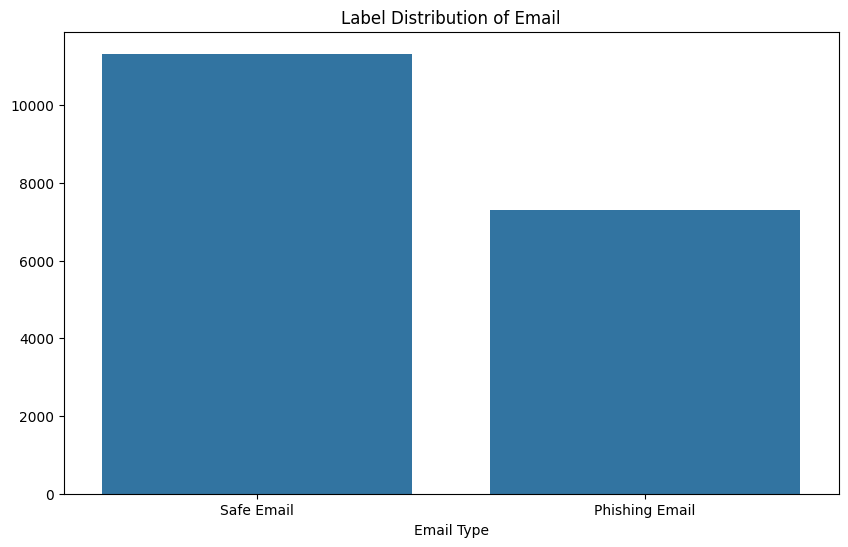

In [19]:
plt.figure(figsize=(10,6))
sns.countplot(x='Email Type', data=df)
plt.xlabel('Email Type')
plt.ylabel('')
plt.title('Label Distribution of Email')
plt.show()

In [21]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 22.3 MB/s eta 0:00:00


In [23]:
df.loc[df['Email Type'] == 'Safe Email'].shape

(11322, 2)

In [24]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
import random
from nlpaug.augmenter.word import SynonymAug, AntonymAug, RandomWordAug, SpellingAug

TARGET_COUNT = 11322
syn_aug = SynonymAug(aug_src='wordnet')
ant_aug = AntonymAug()
random_aug = RandomWordAug(action="swap")
spell_aug = SpellingAug()

def augment_text(text):
    augmenters = [syn_aug, ant_aug, random_aug, spell_aug]
    aug = random.choice(augmenters)
    return aug.augment(text)

def balance_data(df, target_count):
    balanced_df = pd.DataFrame(columns=df.columns)

    for label in df['Email Type'].unique():
        label_df = df[df['Email Type'] == label]
        current_count = len(label_df)

        if current_count < target_count:
            # Augment data
            augmentations_needed = target_count - current_count
            augmented_texts = []
            print(f"Augmenting {label} from {current_count} to {target_count}...")
            for i in range(augmentations_needed):
                text_to_augment = label_df['Email Text'].sample(n=1).values[0]
                augmented_texts.append(augment_text(text_to_augment))
                if (i + 1) % 100 == 0:
                    print(f"Augmented {i + 1}/{augmentations_needed} texts for {label}")

            augmented_df = pd.DataFrame({
                'Email Text': augmented_texts,
                'Email Type': [label] * augmentations_needed
            })
            label_df = pd.concat([label_df, augmented_df])

        elif current_count > target_count:
            # Randomly sample data
            label_df = label_df.sample(n=target_count, random_state=42)

        balanced_df = pd.concat([balanced_df, label_df])

    return balanced_df

## Model
# Balance the dataset
aug_df = balance_data(df,11322)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Augmenting Phishing Email from 7312 to 11322...
Augmented 100/4010 texts for Phishing Email
Augmented 200/4010 texts for Phishing Email
Augmented 300/4010 texts for Phishing Email
Augmented 400/4010 texts for Phishing Email
Augmented 500/4010 texts for Phishing Email
Augmented 600/4010 texts for Phishing Email
Augmented 700/4010 texts for Phishing Email
Augmented 800/4010 texts for Phishing Email
Augmented 900/4010 texts for Phishing Email
Augmented 1000/4010 texts for Phishing Email
Augmented 1100/4010 texts for Phishing Email
Augmented 1200/4010 texts for Phishing Email
Augmented 1300/4010 texts for Phishing Email
Augmented 1400/4010 texts for Phishing Email
Augmented 1500/4010 texts for Phishing Email
Augmented 1600/4010 texts for Phishing Email
Augmented 1700/4010 texts for Phishing Email
Augmented 1800/4010 texts for Phishing Email
Augmented 1900/4010 texts for Phishing Email
Augmented 2000/4010 texts for Phishing Email
Augmented 2100/4010 texts for Phishing Email
Augmented 2200/4

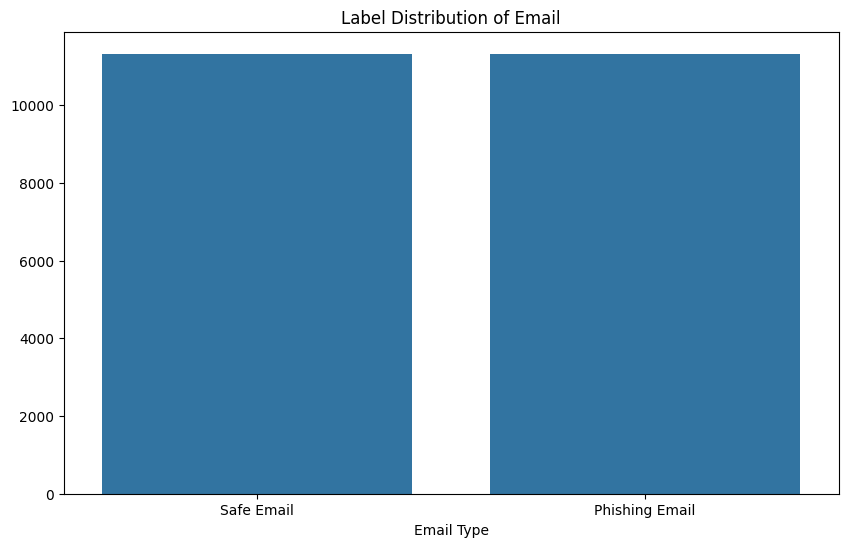

In [25]:
plt.figure(figsize=(10,6))
sns.countplot(x='Email Type', data=aug_df)
plt.xlabel('Email Type')
plt.ylabel('')
plt.title('Label Distribution of Email')
plt.show()

In [26]:
aug_df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
...,...,...
4005,"[aggressive investors information west, vcsc -...",Phishing Email
4006,[really cool but very hot videos! attention! w...,Phishing Email
4007,[adobe 75% off! ! table align = center width =...,Phishing Email
4008,[The Ultimate Traditional & Internet Marketing...,Phishing Email


In [29]:
import re

def clean_text(text):

  if isinstance(text, list):
    text = ' '.join(text)

  # Remove extra !
  text = re.sub(r'!+', '!', text)

  # Remove extra ?
  text = re.sub(r'\?+', '?', text)

  # Remove all punctuation except ! ?
  text = re.sub('[^\w\s!?]', '', text)

  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text)

  # Transform into lowercase
  text = text.lower()

  return text

In [30]:
aug_df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
...,...,...
4005,"[aggressive investors information west, vcsc -...",Phishing Email
4006,[really cool but very hot videos! attention! w...,Phishing Email
4007,[adobe 75% off! ! table align = center width =...,Phishing Email
4008,[The Ultimate Traditional & Internet Marketing...,Phishing Email


In [36]:
cleaned_emails = aug_df['Email Text'].apply(clean_text).tolist()

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cleaned_emails)

In [44]:
y = aug_df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})

In [45]:
y

,Email Type
0,0
1,0
2,0
5,0
6,0
...,...
4005,1
4006,1
4007,1
4008,1


In [46]:
X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.17129606, ..., 0.        , 0.        ,
        0.        ],
       [0.16315493, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02240985, 0.20295616, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [47]:
y.shape[0]

22644

**Prepare the training and testing sets**

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, roc_auc_score, classification_report

In [51]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [52]:
def conf_matrix(model, y_actual, labels=[1, 0]):
  y_predict = model.predict(X_test)
  cm = metrics.confusion_matrix(y_actual, y_predict, labels = [0, 1])
  df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
  group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=labels,fmt='')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

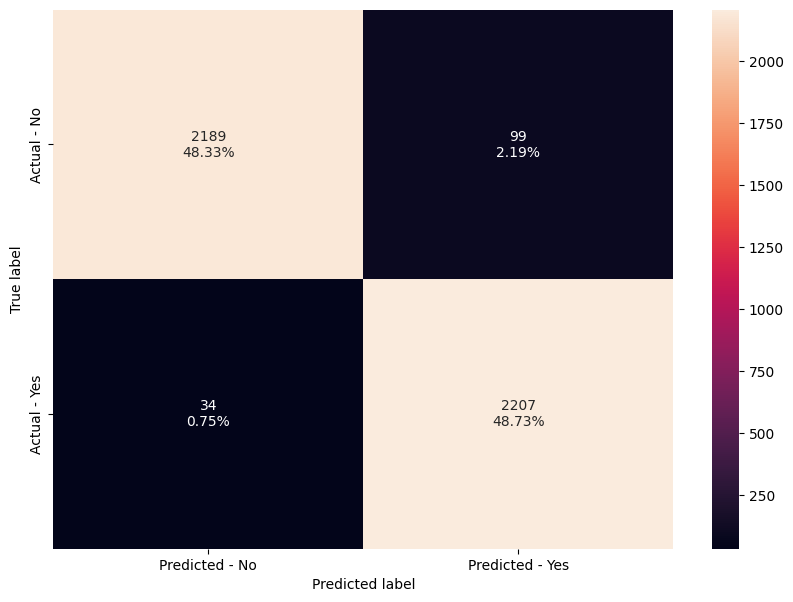

In [53]:
conf_matrix(logistic_model, y_test)

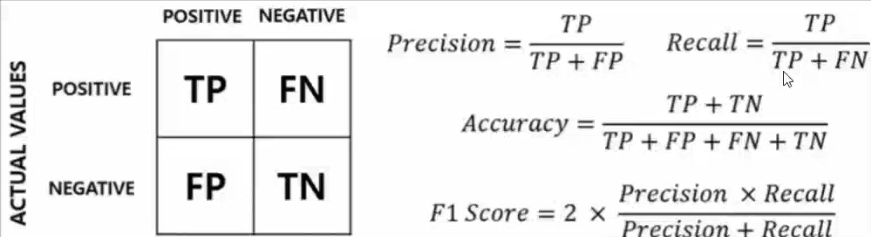

In [55]:
y_pred_logistic = logistic_model.predict(X_test)
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2288
           1       0.96      0.98      0.97      2241

    accuracy                           0.97      4529
   macro avg       0.97      0.97      0.97      4529
weighted avg       0.97      0.97      0.97      4529



In [56]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[]

    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)

    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)

    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)

    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))

    return score_list # returning the list with train and test scores

In [57]:
get_metrics_score(logistic_model);

Accuracy on training set :  0.9779188517802926
Accuracy on test set :  0.9706336939721792
Recall on training set :  0.9897588371324744
Recall on test set :  0.9848282016956715
Precision on training set :  0.9669714900484131
Precision on test set :  0.9570685169124025


Test

In [58]:
dic = {0: 'Safe Email', 1: 'Phishing Email'}

In [61]:
text = 'Dear Alex, Thank you for your recent order from We noticed a slight discrepancy with your shipping address. To ensure your order arrives at the correct location, please verify and update your details by clicking the secure link below: Failure to update your shipping information within 24 hours may result in a delay in the delivery of your order. Sincerely,'

In [62]:
X_phishing = vectorizer.transform([text])

In [64]:
dic[logistic_model.predict(X_phishing)[0]]

'Phishing Email'

In [76]:
txt = 'Hi team, Just a friendly reminder about our meeting tomorrow. We will be discussing the progress on Project X and reviewing the updated timeline. Please come prepared to share any updates on your assigned tasks. If you have any questions before the meeting, feel free to reach out. See you all tomorrow! Best regards,'

In [77]:
X_safe = vectorizer.transform([txt])

In [78]:
dic[logistic_model.predict(X_safe)[0]]

'Safe Email'